In [1]:
import torch
import torch.nn as nn
from collections import OrderedDict
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class ResidualUnit(nn.Module):
    def __init__(self, in_channels, use_bn = False):
        super().__init__()
        self.use_bn = use_bn
        if self.use_bn:
            self.bn1 = nn.BatchNorm2d(in_channels)
            self.bn2 = nn.BatchNorm2d(in_channels)    
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU() # maybe not be required

    def forward(self, x):
        residual = x
        out = x
        if self.use_bn:
            out = self.bn1(x)
        out = self.relu1(out)
        out = self.conv1(out)
        if self.use_bn:
            out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)
        out += residual
        return out

class ResidualPipeline(nn.Module):
    def __init__(self, in_channels, n_units, use_bn = False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1, bias=True)
        layers = []
        for i in range(n_units):
            layers.append(ResidualUnit(64, use_bn))
        self.resnet_stack = nn.Sequential(*layers)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.resnet_stack(x)
        x = self.relu(x) # not there in original paper
        x = self.conv2(x)
        return x

class ExternalEncoder(nn.Module):
    def __init__(self, ext_dim, map_dim):
        super().__init__()
        self.map_dim = map_dim
        self.fcc1 = nn.Linear(ext_dim, 64, bias = True)
        self.fcc2 = nn.Linear(64, np.prod(map_dim), bias = True)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU() # maybe not be required
        
    def forward(self, x):
        x = self.fcc1(x)
        x = self.relu1(x)
        x = self.fcc2(x)
        x = self.relu2(x)
        return x.view(-1, *self.map_dim)
    
class STResnet(nn.Module):
    def __init__(self, c_channel, p_channel, t_channel, n_residual_units, ext_dim, map_dim, use_bn = False):
        super().__init__()
        self.e_pipe = ExternalEncoder(ext_dim, map_dim)
        self.c_pipe = ResidualPipeline(c_channel, n_residual_units, use_bn)
        self.p_pipe = ResidualPipeline(p_channel, n_residual_units, use_bn)
        self.t_pipe = ResidualPipeline(t_channel, n_residual_units, use_bn)
        # 1 dimension for batch processing, this class cannot process unbatched data
        self.w_c = nn.Parameter(torch.randn(1, *map_dim))
        self.w_p = nn.Parameter(torch.randn(1, *map_dim))
        self.w_t = nn.Parameter(torch.randn(1, *map_dim))
        self.tanh = nn.Tanh()
        
    def forward(self, x_c, x_p, x_t, x_e):
        # y_e = self.e_pipe(x_e)
        y_c = self.c_pipe(x_c)
        y_p = self.p_pipe(x_p)
        y_t = self.t_pipe(x_t)
        # Fusion: Eliment wise product (Hadamard Product)
        y = self.w_c*y_c + self.w_p*y_p + self.w_t*y_t
        y = self.tanh(y)
        # y = self.tanh(y+y_e)
        return y

In [3]:
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
from TaxiBJ import TaxiBJDataset
n_closeness = 4
n_period = 1
n_trend = 1
flow_ch = 2 # Inflow and Outflow
n_residual_units = 12
map_dim = (flow_ch, 32, 32) # Specific to dataset
ext_dim = 27
taxibj_dataset_train = TaxiBJDataset('./Datasets/TaxiBJ/',n_closeness,n_period,n_trend,0.8,True)
taxibj_dataset_test = TaxiBJDataset('./Datasets/TaxiBJ/',n_closeness,n_period,n_trend,0.8,False)

min: 0.0 max: 1292.0
min: -15.1 max: 36.1
min: 0.0 max: 31.32
min: 0.0 max: 1292.0
min: -15.1 max: 36.1
min: 0.0 max: 31.32


In [4]:
from tqdm import tqdm
mmn = taxibj_dataset_train.mmn_flow

def train_epoch(model,dataloader,loss_fn,optimizer):
    train_loss = 0.0
    model.train()
    for x_c, x_p, x_t, x_e, y in tqdm(dataloader):
        optimizer.zero_grad()
        output = model(x_c, x_p, x_t, x_e)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss
  
def valid_epoch(model,dataloader,loss_fn):
    valid_loss = 0.0
    model.eval()
    for x_c, x_p, x_t, x_e, y in dataloader:
        output = model(x_c, x_p, x_t, x_e)
        loss = loss_fn(output, y)
        valid_loss += loss.item()
    return valid_loss

In [5]:
import torch.optim as optim
batch_size = 32
num_epochs = 5

train_size = int(0.9 * len(taxibj_dataset_train))
valid_size = len(taxibj_dataset_train) - train_size
train_idx, valid_idx = random_split(range(len(taxibj_dataset_train)), [train_size, valid_size])
train_loader = DataLoader(taxibj_dataset_train, batch_size=batch_size, sampler=SubsetRandomSampler(train_idx))
valid_loader = DataLoader(taxibj_dataset_train, batch_size=batch_size, sampler=SubsetRandomSampler(valid_idx))

model = model = STResnet(n_closeness*flow_ch,n_period*flow_ch,n_trend*flow_ch,n_residual_units,ext_dim,map_dim,True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss(reduction = 'sum')

history = {'train_loss': [], 'valid_loss': []}
for epoch in range(num_epochs):
    train_loss=train_epoch(model,train_loader,loss_fun,optimizer)/len(train_loader.sampler)
    valid_loss=valid_epoch(model,valid_loader,loss_fun)/len(valid_loader.sampler)
    print("Epoch:{}/{} | Training Loss: {} | Validation Loss: {}".format(epoch + 1, num_epochs, train_loss, valid_loss))
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)

# from sklearn.model_selection import KFold
# splits = KFold(n_splits=10,shuffle=True)
# foldperf={}
# least_loss_yet = 2 # maximum loss we can expect, can be any large number
# for fold, (train_idx,valid_idx) in enumerate(splits.split(np.arange(len(taxibj_dataset_train)))):
#     print('Fold {}'.format(fold + 1))
#     train_loader = DataLoader(taxibj_dataset_train, batch_size=batch_size, sampler=SubsetRandomSampler(train_idx))
#     valid_loader = DataLoader(taxibj_dataset_train, batch_size=batch_size, sampler=SubsetRandomSampler(valid_idx))

#     model = model = STResnet(n_closeness*flow_ch,n_period*flow_ch,n_trend*flow_ch,n_residual_units,ext_dim,map_dim,True).to(device)
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
#     loss_fun = nn.MSELoss()

#     history = {'train_loss': [], 'valid_loss': []}
#     for epoch in range(num_epochs):
#         train_loss=train_epoch(model,train_loader,loss_fun,optimizer)
#         valid_loss=valid_epoch(model,valid_loader,loss_fun)
#         print("Epoch:{}/{} | Training Loss: {} | Validation Loss: {}".format(epoch + 1, num_epochs, train_loss, valid_loss))
#         history['train_loss'].append(train_loss)
#         history['valid_loss'].append(valid_loss)
#         if valid_loss < least_loss_yet:
#             print('Saving a better model!')
#             torch.save(model,'checkpoints/k_fold_stresnet.pt')
#             least_loss_yet = valid_loss
        
#     foldperf['fold{}'.format(fold+1)] = history     

100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:29<00:00,  3.02it/s]


Epoch:1/5 | Training Loss: 68.8442228077535 | Validation Loss: 4.869783685746116


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:27<00:00,  3.06it/s]


Epoch:2/5 | Training Loss: 4.033736846789338 | Validation Loss: 3.520721551035525


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:26<00:00,  3.08it/s]


Epoch:3/5 | Training Loss: 3.0669235802927837 | Validation Loss: 3.139791179983208


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:25<00:00,  3.10it/s]


Epoch:4/5 | Training Loss: 2.7142716947258103 | Validation Loss: 3.243248271584957


100%|████████████████████████████████████████████████████████████████████████████████| 451/451 [02:26<00:00,  3.07it/s]


Epoch:5/5 | Training Loss: 2.4919863094668973 | Validation Loss: 2.9347187841727345


In [6]:
import math
test_loader = DataLoader(taxibj_dataset_test, batch_size=batch_size)
test_loss = 0.0
# model = torch.load('Checkpoints/TaxiBJ/k_fold_stresnet.pt')
# model.eval()
for x_c, x_p, x_t, x_e, y in test_loader:
    output = mmn.inverse_transform(model(x_c, x_p, x_t, x_e))
    loss = loss_fun(output, mmn.inverse_transform(y))
    test_loss += loss.item()
rmse_loss = math.sqrt(test_loss/len(test_loader.sampler))
print('Map Root Mean Square Loss: ', rmse_loss)
rmse_loss = math.sqrt(test_loss/(len(test_loader.sampler)*np.prod(map_dim)))
print('Grid Root Mean Square Loss: ', rmse_loss)

Map Root Mean Square Loss:  1046.2840689477368
Grid Root Mean Square Loss:  23.119830006262436


In [7]:
flow_pred = np.zeros((len(taxibj_dataset_test),*map_dim))
flow_org = np.zeros((len(taxibj_dataset_test),*map_dim))
for i in range(len(taxibj_dataset_test)):
    x_c, x_p, x_t, x_e, y = taxibj_dataset_test[i]
    x_e = torch.unsqueeze(x_e, 0)
    x_c = torch.unsqueeze(x_c, 0)
    x_p = torch.unsqueeze(x_p, 0)
    x_t = torch.unsqueeze(x_t, 0)    
    y_pred = model(x_c, x_p, x_t, x_e)
    flow_org[i,:,:,:] = mmn.inverse_transform(y).cpu().detach().numpy()[:,:,:]
    flow_pred[i,:,:,:] = mmn.inverse_transform(y_pred).cpu().detach().numpy()[:,:,:]

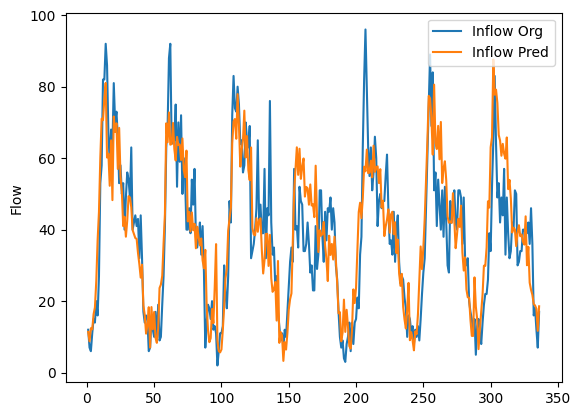

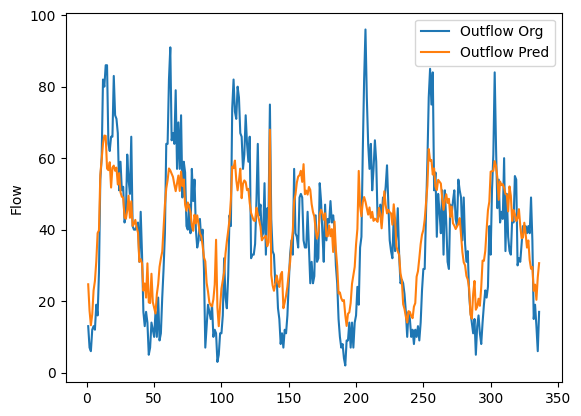

In [8]:
import matplotlib.pyplot as plt
x, y = 10, 10

fig = plt.figure()
in_flow_org = flow_org[24*2*7*0:24*2*7*1,0,x,y]
in_flow_pred = flow_pred[24*2*7*0:24*2*7*1,0,x,y]
t = np.linspace(1, 24*2*7*1, num=24*2*7*1)
plt.plot(t,in_flow_org,label='Inflow Org')
plt.plot(t,in_flow_pred,label='Inflow Pred')
# plt.xticks(np.linspace(1+19, 168+19, num=8),['Tue','Wed','Thr','Fri','Sat','Sun','Mon',''])
# plt.title('Inflow in a busy NYC area from Aug 25 - 7pm to Sep 1 - 7pm, 2014')
plt.ylabel('Flow')
plt.legend(loc='upper right')
plt.show()

fig = plt.figure()
out_flow_org = flow_org[24*2*7*0:24*2*7*1,1,x,y]
out_flow_pred = flow_pred[24*2*7*0:24*2*7*1,1,x,y]
t = np.linspace(1, 24*2*7*1, num=24*2*7*1)
plt.plot(t,out_flow_org,label='Outflow Org')
plt.plot(t,out_flow_pred,label='Outflow Pred')
# plt.xticks(np.linspace(1+19, 168+19, num=8),['Tue','Wed','Thr','Fri','Sat','Sun','Mon',''])
# plt.title('Outflow in a busy NYC area from Aug 25 - 7pm to Sep 1 - 7pm, 2014')
plt.ylabel('Flow')
plt.legend(loc='upper right')
plt.show()